# CHURN

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap

import pickle


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import GridSearchCV

import pickle

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

# Business Understanding​

In [ ]:
df = pd.read_csv('/Users/gonzalodelossantos/Desktop/Data/Nuclio/000# Entregables/02# Aprendizaje Supervisado/data/churn - dataset a entrenar.csv')
df_pred = pd.read_csv('/Users/gonzalodelossantos/Desktop/Data/Nuclio/000# Entregables/02# Aprendizaje Supervisado/data/churn - dataset a predecir.csv')
df_variables = pd.read_csv('/Users/gonzalodelossantos/Desktop/Data/Nuclio/000# Entregables/02# Aprendizaje Supervisado/data/churn - diccionario de variables.csv')

In [3]:
df.head()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.50,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,55.2300,570.50,71.98,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,...,0.0,I,U,U,U,U,U,Y,434.0,1000005
2,82.2750,1312.25,75.00,0.0,0.0,0.0,0.0,156.75,8.1450,52.000000,...,0.0,U,U,U,U,U,U,Y,458.0,1000006
3,17.1450,0.00,16.99,0.0,0.0,0.0,0.0,0.00,-0.1550,0.000000,...,0.0,N,U,U,U,U,U,Y,852.0,1000007
4,38.0525,682.50,52.49,0.0,0.0,0.0,0.0,147.50,-3.0625,9.000000,...,1.0,S,U,U,U,U,U,Y,231.0,1000008


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 86 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               50000 non-null  float64
 1   mou               50000 non-null  float64
 2   totmrc            50000 non-null  float64
 3   ovrmou            50000 non-null  float64
 4   ovrrev            50000 non-null  float64
 5   vceovr            50000 non-null  float64
 6   roam              50000 non-null  float64
 7   change_mou        50000 non-null  float64
 8   change_rev        50000 non-null  float64
 9   drop_vce          50000 non-null  float64
 10  blck_vce          50000 non-null  float64
 11  blck_dat          50000 non-null  float64
 12  unan_vce          50000 non-null  float64
 13  plcd_vce          50000 non-null  float64
 14  recv_vce          50000 non-null  float64
 15  comp_vce          50000 non-null  float64
 16  comp_dat          50000 non-null  float6

In [5]:
df_describe = df.describe()
min_values = df_describe[df_describe.index=='min'].T
negative_values = min_values[min_values['min']<0]
negative_values

,min
totmrc,-26.915
change_mou,-3406.500
change_rev,-1107.740
avg6rev,-2.000
eqpdays,-5.000


In [6]:
df_describe

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,phones,models,truck,rv,lor,income,numbcars,forgntvl,eqpdays,Customer_ID
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.00000,36287.000000,38688.000000,26519.000000,50000.000000,50000.000000,5.000000e+04
mean,59.592453,525.927840,46.757288,42.251626,13.682811,13.423204,1.384443,-14.118840,-1.280641,6.045740,...,1.866500,1.600760,0.198920,0.08816,6.259184,5.804513,1.568724,0.060240,390.685960,1.044602e+06
std,49.442525,541.537185,24.141474,102.904894,31.589805,31.226904,19.091658,292.666852,59.347247,9.179373,...,1.386289,0.937307,0.399192,0.28353,4.762210,2.189491,0.631659,0.237933,251.122428,2.608113e+04
min,0.885000,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,-3406.500000,-1107.740000,0.000000,...,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000,-5.000000,1.000001e+06
25%,33.250000,155.500000,30.000000,0.000000,0.000000,0.000000,0.000000,-85.500000,-7.320000,0.666667,...,1.000000,1.000000,0.000000,0.00000,2.000000,4.000000,1.000000,0.000000,218.000000,1.022040e+06
50%,48.186250,361.750000,44.990000,2.500000,0.875000,0.483750,0.000000,-6.250000,-0.315000,3.000000,...,1.000000,1.000000,0.000000,0.00000,5.000000,6.000000,1.000000,0.000000,349.000000,1.044464e+06
75%,71.578125,719.250000,59.990000,41.250000,13.900000,13.500000,0.257500,62.750000,1.480000,7.666667,...,2.000000,2.000000,0.000000,0.00000,10.000000,7.000000,2.000000,0.000000,530.000000,1.067373e+06
max,3843.262500,12206.750000,409.990000,4320.750000,890.762500,890.762500,3685.200000,31219.250000,9963.657500,232.666667,...,24.000000,15.000000,1.000000,1.00000,15.000000,9.000000,3.000000,1.000000,1698.000000,1.089997e+06


### Valores negativos sin sentido:
#### totmrc: Mean total monthly recurring charge
#### avg6rev: Average monthly revenue over the previous six months
#### eqpdays: Number of days (age) of current equipment
 
 
 

In [7]:
# totmrc
df[df['totmrc']<0]

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
12840,49.3000,77.00,-0.2400,44.50,44.5000,44.500,0.0000,-77.00,-44.3000,0.000000,...,1.0,U,U,U,U,U,U,Y,324.0,1022622
22462,45.8100,814.75,-0.2825,108.75,42.1000,42.100,0.0000,90.25,27.0200,11.333333,...,1.0,H,Y,U,Y,U,U,N,131.0,1039872
23311,4.5250,136.75,-0.2700,10.75,4.3000,4.300,0.0000,-6.75,11.8750,1.000000,...,0.0,N,U,U,U,U,U,N,641.0,1041421
26883,42.2200,121.75,-5.7250,26.75,26.7500,26.750,20.9100,106.25,38.1100,2.666667,...,0.0,U,U,U,U,U,U,N,275.0,1047873
29602,49.4500,0.00,-26.9150,0.00,0.0000,0.000,0.0000,0.00,-44.4500,0.000000,...,0.0,Z,U,U,U,U,U,N,212.0,1052787
29745,7.3175,0.00,-5.2000,0.00,0.0000,0.000,0.0000,0.00,2.6825,0.000000,...,0.0,N,U,U,U,U,U,N,365.0,1053056
33826,8.8200,6.50,-0.2400,6.50,6.5000,6.500,0.0000,-6.50,-3.8200,0.000000,...,0.0,H,U,U,U,U,U,N,318.0,1060597
35796,4.6650,140.25,-0.0825,0.00,0.0000,0.000,0.0000,74.75,0.3250,0.666667,...,0.0,Z,U,U,U,U,U,Y,465.0,1064191
39219,3.5625,156.75,-1.4225,7.00,2.4500,0.875,0.6475,-156.75,-3.5625,1.000000,...,0.0,I,U,U,U,U,U,Y,363.0,1070472
46685,29.7850,530.50,-0.0825,71.50,28.6000,28.600,1.2675,-158.50,-29.7850,3.666667,...,0.0,N,U,U,U,U,U,N,369.0,1083525


In [8]:
# avg6rev
df[df['avg6rev']<0]

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
34524,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,S,U,U,U,U,U,N,371.0,1061910


In [9]:
# eqpdays
df[df['eqpdays']<0]

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
855,77.1625,413.25,70.0000,0.00,0.0000,0.0000,1.9200,208.75,-3.9125,3.000000,...,0.0,N,U,U,U,U,U,Y,-1.0,1001372
2194,45.5100,666.00,44.9900,26.00,9.1000,9.1000,0.3200,35.00,-9.2400,23.333333,...,0.0,Z,U,U,U,U,U,N,-1.0,1003632
4481,62.1725,838.75,81.0375,0.00,0.0000,0.0000,0.0000,138.25,-3.4925,4.666667,...,0.0,U,U,U,U,U,U,N,-3.0,1007582
4985,36.5200,147.75,44.9900,0.00,0.0000,0.0000,0.2925,-124.75,-0.3600,0.000000,...,0.0,N,U,U,U,U,U,Y,-2.0,1008464
5689,76.3900,296.00,29.9900,126.75,46.4000,46.4000,0.0000,106.00,18.8000,1.666667,...,0.0,G,U,U,U,U,U,Y,-3.0,1009682
5883,116.2625,2179.25,74.9925,68.50,26.3500,26.3500,0.0000,-287.25,-34.0625,35.666667,...,0.0,N,U,U,U,U,U,N,-2.0,1010044
8386,111.0625,868.25,75.0000,1.00,0.3900,0.0000,0.5850,-39.25,50.7075,22.666667,...,0.0,N,U,U,U,U,U,Y,-2.0,1014576
9515,46.4775,463.50,34.9800,37.50,11.2500,11.2500,0.0000,6.50,-4.8975,5.000000,...,0.0,N,U,U,U,Y,Y,Y,-4.0,1016657
9977,37.6450,256.00,44.9900,0.00,0.0000,0.0000,0.0000,-179.00,4.5750,8.000000,...,0.0,B,U,U,U,U,U,N,-3.0,1017460
11100,57.3550,1502.75,82.9325,0.00,0.0000,0.0000,0.0000,-128.75,12.3450,16.000000,...,0.0,U,U,U,U,U,U,Y,-5.0,1019523


In [10]:
# ponemos todos los valores en positivo
df['totmrc'] = np.abs(df['totmrc'])
df['avg6rev'] = np.abs(df['avg6rev'])
df['eqpdays'] = np.abs(df['eqpdays'])

df_pred['totmrc'] = np.abs(df['totmrc'])
df_pred['avg6rev'] = np.abs(df['avg6rev'])
df_pred['eqpdays'] = np.abs(df['eqpdays'])

## Outliers

<Axes: xlabel='change_mou'>

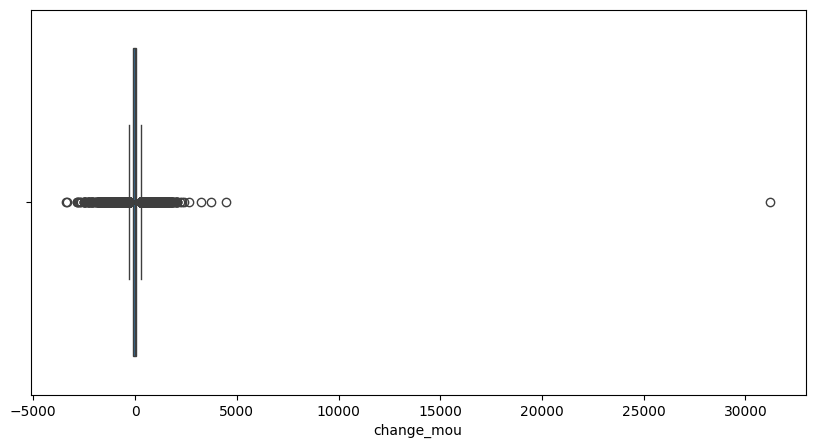

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='change_mou')

In [12]:
df[df['change_mou']>20000][['change_mou','churn']]

,change_mou,churn
22089,31219.25,1


#### change_mou (Percentage change in monthly minutes of use vs previous three month average) tiene un impacto negativo para el modelo. Sin embargo, este registro tiene un valor altisimo de change_mou (>30000) y churn = 1. Eliminamos este outlier:

In [13]:
change_mou_outlier_idx = df[df['change_mou']>20000].index[0]
df.drop(change_mou_outlier_idx, axis=0, inplace=True)

<Axes: xlabel='change_rev'>

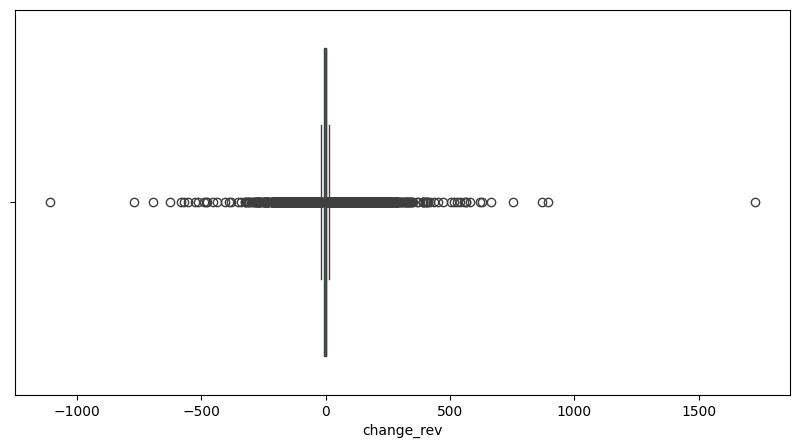

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='change_rev')

## EDA: Analisis Exploratorio

### Distribución de la target

In [15]:
target = 'churn'
df[target].value_counts(normalize=True)

churn
0    0.549031
1    0.450969
Name: proportion, dtype: float64

Text(0, 0.5, 'Frecuencia')

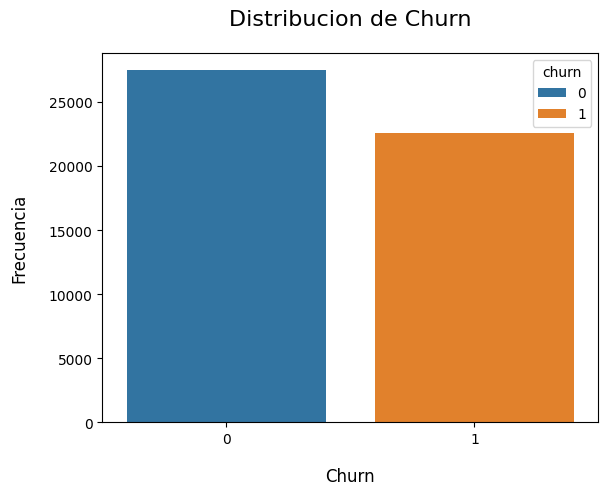

In [16]:
sns.countplot(data=df, 
              x=df[target], 
              hue=df[target])

plt.title('Distribucion de Churn', pad=20, fontsize=16)
plt.xlabel('Churn', labelpad=15, fontsize=12)
plt.ylabel('Frecuencia', labelpad=15, fontsize=12)

### Analisis univariable

In [17]:
# funcion para clasificar nuestras variables por tipos
def obtener_lista_variables(dataset):

    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset.columns:
        if    (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i") and len(dataset[i].unique())!=2 and (i != target):
              lista_numericas.append(i)
        elif  (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i" or dataset[i].dtype.kind=="b" or dataset[i].dtype.kind=="O") and len(dataset[i].unique())==2 and (i != target):
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind=="O") and i != target:
              lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas

In [18]:
lista_numericas, lista_boolean, lista_categoricas = obtener_lista_variables(df)

In [19]:
print('Variables Numericas:', len(lista_numericas))
print('Variables Booleanes:', len(lista_boolean))
print('Variables Categoricas:', len(lista_categoricas))

print('Total:',len(lista_numericas) + len(lista_boolean) + len(lista_categoricas))

Variables Numericas: 65
Variables Booleanes: 12
Variables Categoricas: 8
Total: 85


In [20]:
len(df.columns)

86

In [21]:
# for col in lista_numericas:
#     df.hist(col, bins=50)

In [22]:
# for col in lista_boolean:
#     sns.histplot(data=df, x=col, discrete=True)
#     plt.title(f'Histograma de {col}')
#     plt.show()

In [23]:
# borramos infobase
df.drop(columns='infobase', inplace=True)
df_pred.drop(columns='infobase', inplace=True)

In [24]:
# comprobamos que los Customer_ID no coinciden
df_customer_id = df['Customer_ID'].to_list()
df_pred_customer_id = df_pred['Customer_ID'].to_list()

coincide = [x for x in df_customer_id if x in df_pred_customer_id]
coincide

[]

In [25]:
# nos guardamos los Customer_ID de df_pred
customer_id_pred = df_pred['Customer_ID']
# borramos Customer_ID
df.drop(columns='Customer_ID', inplace=True)
df_pred.drop(columns='Customer_ID', inplace=True)

In [26]:
for col in lista_categoricas:
    print(df[col].value_counts(normalize=True, dropna=False))
    print()

crclscod
AA    0.373367
A     0.175204
BA    0.123242
CA    0.083022
EA    0.066321
B     0.042261
DA    0.037101
ZA    0.036821
C     0.016920
A2    0.008140
U     0.005080
E     0.004040
E4    0.003240
D     0.003020
GA    0.002960
G     0.002580
Z     0.002140
JF    0.002060
M     0.001760
C2    0.001380
W     0.001140
I     0.001140
D4    0.001100
Z4    0.000860
U1    0.000640
V1    0.000580
EM    0.000540
EC    0.000420
B2    0.000360
E2    0.000280
O     0.000280
CY    0.000220
J     0.000200
D5    0.000180
CC    0.000180
Y     0.000180
K     0.000160
C5    0.000160
Z5    0.000120
Z1    0.000120
ZY    0.000100
Z2    0.000080
A3    0.000040
D2    0.000040
TP    0.000040
H     0.000040
EF    0.000040
IF    0.000040
P1    0.000020
GY    0.000020
ZF    0.000020
Name: proportion, dtype: float64

prizm_social_one
S      0.327247
U      0.237825
C      0.170163
T      0.151363
NaN    0.065841
R      0.047561
Name: proportion, dtype: float64

area
NEW YORK CITY AREA               0.11538

In [27]:
# cols_cola_pesada = ['months', 'eqpdays', 'totmrc', 'mou_cvce']

# fig, axs = plt.subplots(ncols=3, nrows=len(cols_cola_pesada), figsize=(12,8))
# axs = axs.reshape(len(cols_cola_pesada), 3)

# for i, col in enumerate(cols_cola_pesada):

#     axs[i, 0].hist(df[col], bins=50)
#     axs[i, 0].set_title(f'{col} - original')

#     axs[i, 1].hist(np.sqrt(df[col]), bins=50, color='red')
#     axs[i, 1].set_title(f'{col} - SQRT')

#     axs[i, 2].hist(np.log1p(df[col]), bins=50, color='green')
#     axs[i, 2].set_title(f'{col} - LOG1P')

# plt.tight_layout(rect=[0, 0, 1, 0.96])  # para no solapar con el título


In [28]:
cols_cola_pesada = ['months', 'eqpdays', 'totmrc', 'mou_cvce']

for col in cols_cola_pesada:
    df[col] = np.sqrt(df[col])
    df_pred[col] = np.sqrt(df_pred[col])

### Analisis variables-target

In [29]:
# graficos_por_fila = 4
# variables = list(df.columns)
# variables.remove(target)
# num_variables =len(variables)

# fig, axs = plt.subplots(ncols=graficos_por_fila, nrows=(num_variables + graficos_por_fila - 1) // graficos_por_fila, figsize=(15,60))
# axs = axs.flatten()

# for i, var in enumerate(variables):
#     sns.scatterplot(data=df, x=var, y=target, ax=axs[i], hue=target)
#     axs[i].set_title(f'{var} vs {target}')
#     axs[i].set_xlabel(var)
#     axs[i].set_ylabel(target)

# plt.tight_layout()

# train-test-split
### separamos el df en df_train y df_test para evitar leakage

In [30]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

df_train.reset_index(drop='index', inplace=True)
df_test.reset_index(drop='index', inplace=True)

In [31]:
df_test['ethnic'].value_counts(normalize=True)

ethnic
N    0.3362
H    0.1360
S    0.1306
U    0.1087
G    0.0636
Z    0.0533
I    0.0405
O    0.0403
J    0.0305
F    0.0231
B    0.0137
R    0.0117
D    0.0096
M    0.0013
P    0.0009
Name: proportion, dtype: float64

# Preprocessing

## Data Cleaning

### Duplicados

In [32]:
df[df.duplicated()]

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,numbcars,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays


## Tratamiento de nulos

In [33]:
# df_train_nulos
df_train_nulos = df_train.isna().sum().reset_index(name='nulls')
df_train_nulos[df_train_nulos['nulls']>0].sort_values(by='nulls')

,index,nulls
61,area,183
60,prizm_social_one,2679
67,hnd_webcap,3971
73,income,9028
71,lor,10936
70,ownrent,12333
74,numbcars,18754


In [34]:
# df_test_nulos
df_test_nulos = df_test.isna().sum().reset_index(name='nulls')
df_test_nulos[df_test_nulos['nulls']>0].sort_values(by='nulls')

,index,nulls
61,area,537
60,prizm_social_one,613
67,hnd_webcap,1000
73,income,2284
71,lor,2777
70,ownrent,3113
74,numbcars,4726


In [35]:
# df_pred nulos
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls
6,roam,25
61,dualband,25
59,prizm_social_one,88
66,hnd_webcap,155
72,income,305
70,lor,390
69,ownrent,427
73,numbcars,676


In [36]:
df_pred[df_pred['eqpdays'].isna()]

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,numbcars,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays


### area

In [37]:
df_train['area'].value_counts(dropna=False, normalize=True)*100

area
NEW YORK CITY AREA               11.590290
DC/MARYLAND/VIRGINIA AREA         6.757669
MIDWEST AREA                      6.632666
ATLANTIC SOUTH AREA               6.095152
CALIFORNIA NORTH AREA             5.930148
DALLAS AREA                       5.790145
NEW ENGLAND AREA                  5.430136
SOUTHWEST AREA                    5.355134
CHICAGO AREA                      5.172629
OHIO AREA                         4.940124
LOS ANGELES AREA                  4.935123
GREAT LAKES AREA                  4.907623
CENTRAL/SOUTH TEXAS AREA          4.345109
HOUSTON AREA                      4.300108
NORTHWEST/ROCKY MOUNTAIN AREA     4.297607
NORTH FLORIDA AREA                4.182605
SOUTH FLORIDA AREA                3.465087
TENNESSEE AREA                    2.850071
PHILADELPHIA AREA                 2.565064
NaN                               0.457511
Name: proportion, dtype: float64

##### No tenemos manera de saber el area. Imputamos 'Unknown'

In [38]:
# Imputamos 'Unknown'
df_train['area'].fillna('Unknown', inplace=True)
df_test['area'].fillna('Unknown', inplace=True)

df_train['area'].value_counts(dropna=False, normalize=True)*100

area
NEW YORK CITY AREA               11.590290
DC/MARYLAND/VIRGINIA AREA         6.757669
MIDWEST AREA                      6.632666
ATLANTIC SOUTH AREA               6.095152
CALIFORNIA NORTH AREA             5.930148
DALLAS AREA                       5.790145
NEW ENGLAND AREA                  5.430136
SOUTHWEST AREA                    5.355134
CHICAGO AREA                      5.172629
OHIO AREA                         4.940124
LOS ANGELES AREA                  4.935123
GREAT LAKES AREA                  4.907623
CENTRAL/SOUTH TEXAS AREA          4.345109
HOUSTON AREA                      4.300108
NORTHWEST/ROCKY MOUNTAIN AREA     4.297607
NORTH FLORIDA AREA                4.182605
SOUTH FLORIDA AREA                3.465087
TENNESSEE AREA                    2.850071
PHILADELPHIA AREA                 2.565064
Unknown                           0.457511
Name: proportion, dtype: float64

### prizm_social_one: "Social group letter only"
##### probablemente signifiquen 'Suburban', 'Urban', 'Country', 'Town', 'Rural'. No podemos clasificarlos ordinalmente

In [39]:
df_train['prizm_social_one'].value_counts(dropna=False, normalize=True)*100

prizm_social_one
S      32.675817
U      23.650591
C      17.090427
T      15.147879
NaN     6.697667
R       4.737618
Name: proportion, dtype: float64

In [40]:
# Imputamos 'Unknown'
df_train['prizm_social_one'].fillna('Unknown', inplace=True)
df_test['prizm_social_one'].fillna('Unknown', inplace=True)
df_pred['prizm_social_one'].fillna('Unknown', inplace=True)

df_train['prizm_social_one'].value_counts(dropna=False, normalize=True)*100

prizm_social_one
S          32.675817
U          23.650591
C          17.090427
T          15.147879
Unknown     6.697667
R           4.737618
Name: proportion, dtype: float64

### hnd_webcap: "Handset web capability"
##### Capacidad del dispositivo para acceder a la web. Podemos clasificar los nulos como 'Unknown'

In [41]:
df_train['hnd_webcap'].value_counts(dropna=False, normalize=True)*100

hnd_webcap
WCMB    77.109428
WC      12.962824
NaN      9.927748
Name: proportion, dtype: float64

In [42]:
# Imputamos 'Unknown'
df_train['hnd_webcap'].fillna('Unknown', inplace=True)
df_test['hnd_webcap'].fillna('Unknown', inplace=True)
df_pred['hnd_webcap'].fillna('Unknown', inplace=True)

df_train['hnd_webcap'].value_counts(dropna=False, normalize=True)*100

hnd_webcap
WCMB       77.109428
WC         12.962824
Unknown     9.927748
Name: proportion, dtype: float64

### income: "Estimated income"

In [43]:
df_train['income'].value_counts(dropna=False, normalize=True)*100

income
NaN    22.570564
6.0    19.457986
7.0    12.012800
9.0    11.627791
5.0     8.317708
4.0     8.017700
3.0     6.152654
8.0     5.365134
1.0     4.065102
2.0     2.412560
Name: proportion, dtype: float64

##### Los numeros de income (1-9) representan grupos de ingresos. Vamos a ver cuanto gasta al mes grupo uno de media:

In [44]:
df_train.groupby('income', dropna=False)['rev'].mean().sort_index()


income
1.0    62.975426
2.0    61.115884
3.0    60.018653
4.0    57.704781
5.0    58.332160
6.0    56.162485
7.0    56.354077
8.0    58.750477
9.0    56.882116
NaN    65.996590
Name: rev, dtype: float64

##### Siguen un orden lineal de gasto. Asumiremos que los NaN tienen income = 0.0

In [45]:
# Imputamos 0.0
df_train['income'].fillna(0.0, inplace=True)
df_test['income'].fillna(0.0, inplace=True)
df_pred['income'].fillna(0.0, inplace=True)

df_train['income'].value_counts(dropna=False, normalize=True)*100

income
0.0    22.570564
6.0    19.457986
7.0    12.012800
9.0    11.627791
5.0     8.317708
4.0     8.017700
3.0     6.152654
8.0     5.365134
1.0     4.065102
2.0     2.412560
Name: proportion, dtype: float64

### lor: "Length of residence"
##### Representa el tiempo que lleva el cliente viviendo en su domicilio actual

In [46]:
df_train['lor'].value_counts(dropna=False, normalize=True)*100

lor
NaN     27.340684
1.0     10.312758
2.0      9.067727
15.0     8.740219
3.0      6.077652
4.0      5.405135
5.0      5.202630
6.0      4.657616
7.0      4.430111
8.0      3.885097
9.0      3.107578
10.0     2.432561
0.0      2.335058
11.0     2.122553
13.0     1.835046
12.0     1.795045
14.0     1.252531
Name: proportion, dtype: float64

##### No tenemos ni idea de que puede ser NaN, asi que imputaremos Unknown
##### Para evitar generar demasiadas columnas con el OneHotEncoder, dividiremos los valores en categorias

<Axes: xlabel='lor', ylabel='churn'>

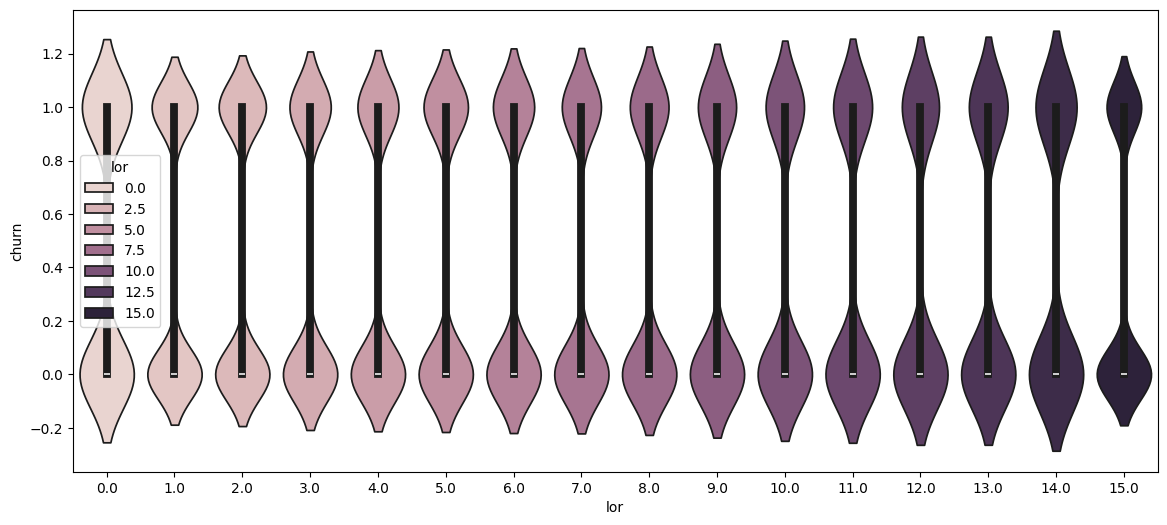

In [47]:
plt.figure(figsize=(14,6))
sns.violinplot(data=df_train, x='lor', y=target, hue='lor')

In [48]:
# 0-3, 4-6, 7-9, 10-12, 13-15, Unknown
def lor_cat(year):
    if pd.isna(year):
        return 'Unknown'
    if year >= 0.0 and year <=3.0:
        return '0-3'
    if year >= 4.0 and year <=6.0:
        return '4-6'
    if year >= 7.0 and year <=9.0:
        return '7-9'
    if year >= 10.0 and year <=12.0:
        return '10-12'
    if year >= 13.0:
        return '13-15'
    return 'Other'

In [49]:
# nos guardamos el valor original de df['lor']
lor_original = df_train['lor']

# aplicamos la funcion a df y df_pred
df_train['lor'] = df_train['lor'].apply(lambda x: lor_cat(x))
df_test['lor'] = df_test['lor'].apply(lambda x: lor_cat(x))
df_pred['lor'] = df_pred['lor'].apply(lambda x: lor_cat(x))

# comprobamos que ha funcionado como esperabamos
df_train[['lor']].merge(lor_original, left_index=True, right_index=True)

,lor_x,lor_y
0,13-15,15.0
1,0-3,3.0
2,0-3,2.0
3,Unknown,NaN
4,0-3,2.0
...,...,...
39994,10-12,10.0
39995,Unknown,NaN
39996,Unknown,NaN
39997,7-9,8.0


In [50]:
df_train['lor'].value_counts(normalize=True)*100

lor
0-3        27.793195
Unknown    27.340684
4-6        15.265382
13-15      11.827796
7-9        11.422786
10-12       6.350159
Name: proportion, dtype: float64

<Axes: xlabel='lor', ylabel='churn'>

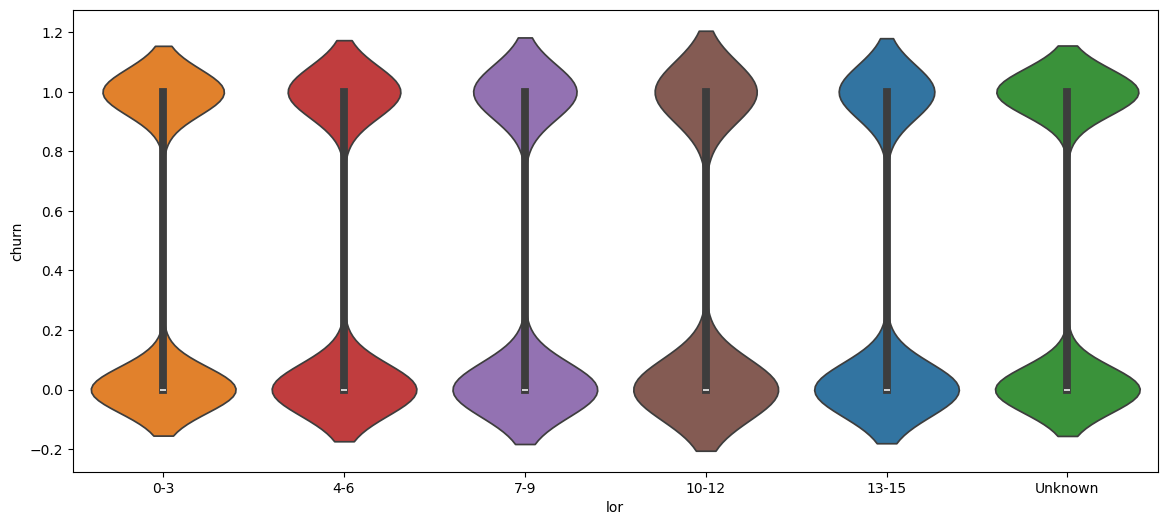

In [51]:
order = ['0-3', '4-6', '7-9', '10-12', '13-15', 'Unknown']
plt.figure(figsize=(14,6))
sns.violinplot(data=df_train, x='lor', y=target, hue='lor', order=order)

### ownrent: "Home owner/renter status"
##### Representa si el cliente tiene una casa en propiedad o vive de alquiler

In [52]:
df_train['ownrent'].value_counts(dropna=False, normalize=True)*100

ownrent
O      67.139178
NaN    30.833271
R       2.027551
Name: proportion, dtype: float64

In [53]:
# Imputamos 'Unknown'
df_train['ownrent'].fillna('Unknown', inplace=True)
df_test['ownrent'].fillna('Unknown', inplace=True)
df_pred['ownrent'].fillna('Unknown', inplace=True)

df_train['ownrent'].value_counts(dropna=False, normalize=True)*100

ownrent
O          67.139178
Unknown    30.833271
R           2.027551
Name: proportion, dtype: float64

### numbcars: "Known number of vehicles"

In [54]:
df_train['numbcars'].value_counts(dropna=False, normalize=True)*100

numbcars
NaN    46.886172
1.0    27.015675
2.0    21.975549
3.0     4.122603
Name: proportion, dtype: float64

##### Asumimos que los NaN no tienen coche

In [55]:
# Imputamos 0.0
df_train['numbcars'].fillna(0.0, inplace=True)
df_test['numbcars'].fillna(0.0, inplace=True)
df_pred['numbcars'].fillna(0.0, inplace=True)

df_train['numbcars'].value_counts(dropna=False, normalize=True)*100

numbcars
0.0    46.886172
1.0    27.015675
2.0    21.975549
3.0     4.122603
Name: proportion, dtype: float64

##### df_train_nulls restantes

In [56]:
df_train_nulls = df_train.isna().sum().reset_index(name='nulls')
df_train_nulls[df_train_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls


In [57]:
df_test_nulls = df_test.isna().sum().reset_index(name='nulls')
df_test_nulls[df_test_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls


##### df_pred_nulls restantes


In [58]:
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls
6,roam,25
61,dualband,25


### roam: "Mean number of roaming calls"

In [59]:
df_pred['roam'].value_counts(dropna=False, normalize=True)*100

roam
0.0000     65.400000
0.0975      3.466667
NaN         1.666667
0.1600      1.466667
0.1950      1.266667
             ...    
0.6900      0.066667
2.7700      0.066667
0.7150      0.066667
10.6700     0.066667
3.8825      0.066667
Name: proportion, Length: 309, dtype: float64

In [60]:
# Imputamos la mediana
df_pred['roam'].fillna(df_pred['roam'].median(), inplace=True)

df_pred['roam'].value_counts(dropna=False, normalize=True)*100

roam
0.0000     67.066667
0.0975      3.466667
0.1600      1.466667
0.1950      1.266667
0.3200      0.733333
             ...    
0.6900      0.066667
2.7700      0.066667
0.7150      0.066667
10.6700     0.066667
3.8825      0.066667
Name: proportion, Length: 308, dtype: float64

### dualband

In [61]:
df_pred['dualband'].value_counts(dropna=False, normalize=True)*100

dualband
Y      73.400000
N      21.933333
T       3.000000
NaN     1.666667
Name: proportion, dtype: float64

In [62]:
# Imputamos la moda
df_pred['dualband'].fillna(df_pred['dualband'].mode()[0], inplace=True)

df_pred['dualband'].value_counts(dropna=False, normalize=True)*100

dualband
Y    75.066667
N    21.933333
T     3.000000
Name: proportion, dtype: float64

### eqpdays

In [63]:
df_pred['eqpdays'].value_counts(dropna=False, normalize=True)*100

eqpdays
9.273618     0.466667
13.228757    0.400000
5.196152     0.400000
36.055513    0.400000
17.117243    0.400000
               ...   
19.974984    0.066667
39.127995    0.066667
30.870698    0.066667
17.860571    0.066667
36.551334    0.066667
Name: proportion, Length: 848, dtype: float64

In [64]:
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls


## Tratamiento de variables categóricas

In [65]:
df_train.select_dtypes(include='object').columns

Index(['crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband',
       'refurb_new', 'hnd_webcap', 'ownrent', 'lor', 'marital', 'ethnic',
       'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

### crclscod: "Credit class code"

In [66]:
df_crclscod = df_train['crclscod'].value_counts(normalize=True).reset_index()
df_crclscod['cumsum'] = df_crclscod['proportion'].cumsum()
df_crclscod

,crclscod,proportion,cumsum
0,AA,0.373709,0.373709
1,A,0.175629,0.549339
2,BA,0.123678,0.673017
3,CA,0.083327,0.756344
4,EA,0.065352,0.821696
5,B,0.042376,0.864072
6,ZA,0.036951,0.901023
7,DA,0.036351,0.937373
8,C,0.017050,0.954424
9,A2,0.008350,0.962774


In [67]:
top_90_crclscod = df_crclscod[df_crclscod['cumsum']<0.9]
top_90_crclscod = top_90_crclscod['crclscod'].to_list()

In [68]:
df_train['crclscod'] = df_train['crclscod'].apply(lambda x: x if x in top_90_crclscod else 'other')
df_test['crclscod'] = df_test['crclscod'].apply(lambda x: x if x in top_90_crclscod else 'other')
df_pred['crclscod'] = df_pred['crclscod'].apply(lambda x: x if x in top_90_crclscod else 'other')

df_train['crclscod'].value_counts(normalize=True, ascending=False)

crclscod
AA       0.373709
A        0.175629
other    0.135928
BA       0.123678
CA       0.083327
EA       0.065352
B        0.042376
Name: proportion, dtype: float64

### area

In [69]:
df_train['area'].value_counts(normalize=True)*100

area
NEW YORK CITY AREA               11.590290
DC/MARYLAND/VIRGINIA AREA         6.757669
MIDWEST AREA                      6.632666
ATLANTIC SOUTH AREA               6.095152
CALIFORNIA NORTH AREA             5.930148
DALLAS AREA                       5.790145
NEW ENGLAND AREA                  5.430136
SOUTHWEST AREA                    5.355134
CHICAGO AREA                      5.172629
OHIO AREA                         4.940124
LOS ANGELES AREA                  4.935123
GREAT LAKES AREA                  4.907623
CENTRAL/SOUTH TEXAS AREA          4.345109
HOUSTON AREA                      4.300108
NORTHWEST/ROCKY MOUNTAIN AREA     4.297607
NORTH FLORIDA AREA                4.182605
SOUTH FLORIDA AREA                3.465087
TENNESSEE AREA                    2.850071
PHILADELPHIA AREA                 2.565064
Unknown                           0.457511
Name: proportion, dtype: float64

In [70]:
# area va a introducir mucho ruido en el modelo (demasiadas columnas). La borramos
df_train.drop(columns='area', inplace=True)
df_test.drop(columns='area', inplace=True)
df_pred.drop(columns='area', inplace=True)

### ethnic

In [71]:
df_test['ethnic'].value_counts(normalize=True)

ethnic
N    0.3362
H    0.1360
S    0.1306
U    0.1087
G    0.0636
Z    0.0533
I    0.0405
O    0.0403
J    0.0305
F    0.0231
B    0.0137
R    0.0117
D    0.0096
M    0.0013
P    0.0009
Name: proportion, dtype: float64

In [72]:
df_train['ethnic'].value_counts(normalize=True).cumsum()

ethnic
N    0.345909
H    0.481187
S    0.612290
U    0.723168
G    0.782920
Z    0.832296
O    0.873647
I    0.913073
J    0.942899
F    0.964049
B    0.978449
R    0.988750
D    0.997250
M    0.998675
P    0.999950
X    1.000000
Name: proportion, dtype: float64

In [73]:
df_pred['ethnic'].value_counts(normalize=True).cumsum()

ethnic
N    0.374000
S    0.498667
H    0.618667
U    0.728667
G    0.791333
Z    0.841333
O    0.884667
I    0.915333
F    0.938000
J    0.960000
R    0.978000
B    0.991333
D    0.998000
M    0.999333
P    1.000000
Name: proportion, dtype: float64

In [74]:
df_ethnic = df_train['ethnic'].value_counts(normalize=True).reset_index()
df_ethnic['cumsum'] = df_ethnic['proportion'].cumsum()
df_ethnic

,ethnic,proportion,cumsum
0,N,0.345909,0.345909
1,H,0.135278,0.481187
2,S,0.131103,0.612290
3,U,0.110878,0.723168
4,G,0.059751,0.782920
5,Z,0.049376,0.832296
6,O,0.041351,0.873647
7,I,0.039426,0.913073
8,J,0.029826,0.942899
9,F,0.021151,0.964049


In [75]:
df_ethnic_test = df_test['ethnic'].value_counts(normalize=True).reset_index()
df_ethnic_test['cumsum'] = df_ethnic_test['proportion'].cumsum()
df_ethnic_test

,ethnic,proportion,cumsum
0,N,0.3362,0.3362
1,H,0.1360,0.4722
2,S,0.1306,0.6028
3,U,0.1087,0.7115
4,G,0.0636,0.7751
5,Z,0.0533,0.8284
6,I,0.0405,0.8689
7,O,0.0403,0.9092
8,J,0.0305,0.9397
9,F,0.0231,0.9628


In [76]:
ethnic_top90 = df_ethnic[df_ethnic['cumsum']<0.9]
ethnic_top90 = ethnic_top90['ethnic'].to_list()
ethnic_top90

['N', 'H', 'S', 'U', 'G', 'Z', 'O']

In [77]:
df_train['ethnic'] = df_train['ethnic'].apply(lambda x: x if x in ethnic_top90 else 'other')
df_test['ethnic'] = df_test['ethnic'].apply(lambda x: x if x in ethnic_top90 else 'other')
df_pred['ethnic'] = df_pred['ethnic'].apply(lambda x: x if x in ethnic_top90 else 'other')

df_train['ethnic'].value_counts(normalize=True)

ethnic
N        0.345909
H        0.135278
S        0.131103
other    0.126353
U        0.110878
G        0.059751
Z        0.049376
O        0.041351
Name: proportion, dtype: float64

In [78]:
df_test['ethnic'].value_counts(normalize=True)

ethnic
N        0.3362
H        0.1360
other    0.1313
S        0.1306
U        0.1087
G        0.0636
Z        0.0533
O        0.0403
Name: proportion, dtype: float64

In [79]:
df_pred['ethnic'].value_counts(normalize=True)

ethnic
N        0.374000
S        0.124667
H        0.120000
other    0.115333
U        0.110000
G        0.062667
Z        0.050000
O        0.043333
Name: proportion, dtype: float64

### variables categoricas booleanas

In [80]:
# asl_flag
df_train['asl_flag'] = df_train['asl_flag'].apply(lambda x: 0 if x=='N' else 1)
df_test['asl_flag'] = df_test['asl_flag'].apply(lambda x: 0 if x=='N' else 1)
df_pred['asl_flag'] = df_pred['asl_flag'].apply(lambda x: 0 if x=='N' else 1)

df_train['asl_flag'].value_counts(normalize=True)

asl_flag
0    0.877272
1    0.122728
Name: proportion, dtype: float64

In [81]:
# refurb_new
df_train['refurb_new'] = df_train['refurb_new'].apply(lambda x: 0 if x=='N' else 1)
df_test['refurb_new'] = df_test['refurb_new'].apply(lambda x: 0 if x=='N' else 1)
df_pred['refurb_new'] = df_pred['refurb_new'].apply(lambda x: 0 if x=='N' else 1)

df_train['refurb_new'].value_counts()

refurb_new
0    34103
1     5896
Name: count, dtype: int64

In [82]:
# kid0_2
df_train['kid0_2'] = df_train['kid0_2'].apply(lambda x: 0 if x=='U' else 1)
df_test['kid0_2'] = df_test['kid0_2'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid0_2'] = df_pred['kid0_2'].apply(lambda x: 0 if x=='U' else 1)

df_train['kid0_2'].value_counts()

kid0_2
0    38348
1     1651
Name: count, dtype: int64

In [83]:
# kid3_5
df_train['kid3_5'] = df_train['kid3_5'].apply(lambda x: 0 if x=='U' else 1)
df_test['kid3_5'] = df_test['kid3_5'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid3_5'] = df_pred['kid3_5'].apply(lambda x: 0 if x=='U' else 1)

df_train['kid3_5'].value_counts()

kid3_5
0    38114
1     1885
Name: count, dtype: int64

In [84]:
# kid6_10
df_train['kid6_10'] = df_train['kid6_10'].apply(lambda x: 0 if x=='U' else 1)
df_test['kid6_10'] = df_test['kid6_10'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid6_10'] = df_pred['kid6_10'].apply(lambda x: 0 if x=='U' else 1)

df_train['kid6_10'].value_counts()

kid6_10
0    36678
1     3321
Name: count, dtype: int64

In [85]:
# kid11_15
df_train['kid11_15'] = df_train['kid11_15'].apply(lambda x: 0 if x=='U' else 1)
df_test['kid11_15'] = df_test['kid11_15'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid11_15'] = df_pred['kid11_15'].apply(lambda x: 0 if x=='U' else 1)

df_train['kid11_15'].value_counts()

kid11_15
0    36345
1     3654
Name: count, dtype: int64

In [86]:
# kid16_17
df_train['kid16_17'] = df_train['kid16_17'].apply(lambda x: 0 if x=='U' else 1)
df_test['kid16_17'] = df_test['kid16_17'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid16_17'] = df_pred['kid16_17'].apply(lambda x: 0 if x=='U' else 1)

df_train['kid16_17'].value_counts()

kid16_17
0    35856
1     4143
Name: count, dtype: int64

In [87]:
# creditcd
df_train['creditcd'] = df_train['creditcd'].apply(lambda x: 0 if x=='N' else 1)
df_test['creditcd'] = df_test['creditcd'].apply(lambda x: 0 if x=='N' else 1)
df_pred['creditcd'] = df_pred['creditcd'].apply(lambda x: 0 if x=='N' else 1)

df_train['creditcd'].value_counts()

creditcd
1    28183
0    11816
Name: count, dtype: int64

### one hot encoding

In [88]:
cols_categoricas = df_train.select_dtypes(include='object').columns.to_list()
cols_categoricas

['crclscod',
 'prizm_social_one',
 'dualband',
 'hnd_webcap',
 'ownrent',
 'lor',
 'marital',
 'ethnic']

In [89]:
encoder = OneHotEncoder(sparse_output=False)

data_encoded = encoder.fit_transform(df_train[cols_categoricas])
df_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out())
df_train.drop(columns=cols_categoricas, inplace=True)
df_train = df_train.merge(df_encoded, left_index=True, right_index=True)
df_train.head()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,marital_S,marital_U,ethnic_G,ethnic_H,ethnic_N,ethnic_O,ethnic_S,ethnic_U,ethnic_Z,ethnic_other
0,34.4850,279.50,6.323765,0.00,0.0000,0.0000,0.0000,65.50,-0.4950,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,64.6800,513.50,6.745183,86.75,34.7000,34.7000,0.3125,-166.50,-30.4900,2.333333,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,50.4850,225.25,7.745321,0.00,0.0000,0.0000,0.0000,-153.25,-0.4950,3.666667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74.5500,978.00,7.001785,64.75,22.6625,22.6625,2.3675,-648.00,-118.4200,2.666667,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.5575,785.00,7.410128,16.00,5.2250,5.2250,1.2000,391.00,-16.7975,18.666667,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df_train.columns.to_list()

['rev',
 'mou',
 'totmrc',
 'ovrmou',
 'ovrrev',
 'vceovr',
 'roam',
 'change_mou',
 'change_rev',
 'drop_vce',
 'blck_vce',
 'blck_dat',
 'unan_vce',
 'plcd_vce',
 'recv_vce',
 'comp_vce',
 'comp_dat',
 'custcare',
 'ccrndmou',
 'cc_mou',
 'inonemin',
 'threeway',
 'mou_cvce',
 'mou_rvce',
 'owylis_vce',
 'mouowylisv',
 'iwylis_vce',
 'mouiwylisv',
 'peak_vce',
 'peak_dat',
 'mou_peav',
 'opk_vce',
 'opk_dat',
 'mou_opkv',
 'mou_opkd',
 'drop_blk',
 'attempt',
 'complete',
 'callwait',
 'churn',
 'months',
 'uniqsubs',
 'actvsubs',
 'asl_flag',
 'totcalls',
 'totmou',
 'totrev',
 'adjrev',
 'adjmou',
 'adjqty',
 'avgrev',
 'avgmou',
 'avgqty',
 'avg3mou',
 'avg3qty',
 'avg3rev',
 'avg6mou',
 'avg6qty',
 'avg6rev',
 'refurb_new',
 'hnd_price',
 'phones',
 'models',
 'truck',
 'rv',
 'income',
 'numbcars',
 'forgntvl',
 'kid0_2',
 'kid3_5',
 'kid6_10',
 'kid11_15',
 'kid16_17',
 'creditcd',
 'eqpdays',
 'crclscod_A',
 'crclscod_AA',
 'crclscod_B',
 'crclscod_BA',
 'crclscod_CA',
 'crcls

In [925]:
# aplicamos las transformaciones al df_test
data_encoded = encoder.transform(df_test[cols_categoricas])
df_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out())
df_test.drop(columns=cols_categoricas, inplace=True)
df_test = df_test.merge(df_encoded, left_index=True, right_index=True)
df_test.head()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,marital_S,marital_U,ethnic_G,ethnic_H,ethnic_N,ethnic_O,ethnic_S,ethnic_U,ethnic_Z,ethnic_other
0,62.3500,433.75,8.366003,30.25,10.92,2.925,0.0,288.25,21.8100,6.666667,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,52.2175,562.50,6.230369,42.75,13.40,12.425,0.0,-95.50,-10.2775,10.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,105.3675,1206.50,8.660254,0.00,0.00,0.000,0.0,134.50,9.8625,8.666667,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,59.7400,345.25,7.070361,32.50,9.75,9.750,0.0,93.75,-9.7500,0.666667,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54.1900,676.00,7.070361,12.00,3.60,3.600,0.0,-99.00,-4.2000,23.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [926]:
# aplicamos las transformaciones a df_pred
data_pred_encoded = encoder.transform(df_pred[cols_categoricas])
df_pred_encoded = pd.DataFrame(data_pred_encoded, columns=encoder.get_feature_names_out())
df_pred.drop(columns=cols_categoricas, inplace=True)
df_pred = df_pred.merge(df_pred_encoded, left_index=True, right_index=True)
df_pred.head()


,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,marital_S,marital_U,ethnic_G,ethnic_H,ethnic_N,ethnic_O,ethnic_S,ethnic_U,ethnic_Z,ethnic_other
0,31.4475,56.00,4.743416,8.75,1.4475,1.4475,0.0000,-34.00,-1.4475,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,76.7375,1007.75,8.484103,65.25,19.5750,19.5750,6.6775,-51.75,5.3625,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,159.0400,2542.50,8.660254,458.25,45.8250,45.8250,9.5600,-225.50,-19.3600,34.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,67.2750,602.50,4.121893,73.25,7.3250,7.3250,4.8000,-155.50,-12.8250,21.666667,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,80.2825,1245.25,7.244998,73.00,18.2500,18.2500,0.0000,-160.25,-62.0725,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Alta correlación

In [927]:
df_corr = df_train.corr(numeric_only=True)
df_corr.style.background_gradient(cmap='coolwarm')

In [928]:
# nos quedamos con el triangulo superior
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df_train.columns)
df_triangulo.index=df_train.columns
df_triangulo.head()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,marital_S,marital_U,ethnic_G,ethnic_H,ethnic_N,ethnic_O,ethnic_S,ethnic_U,ethnic_Z,ethnic_other
rev,0.0,0.721563,0.595484,0.801738,0.805934,0.800906,0.307236,-0.042895,-0.065121,0.441445,...,0.013908,0.072812,-0.010196,0.032336,-0.021791,-0.039601,0.005677,-0.007793,0.052721,-0.003865
mou,0.0,0.000000,0.554471,0.584108,0.543100,0.542051,0.127407,-0.043707,-0.057785,0.602261,...,0.027381,0.109600,-0.030375,0.059791,-0.051933,-0.004745,-0.009249,-0.008201,0.078945,0.002981
totmrc,0.0,0.000000,0.000000,0.198356,0.165738,0.163975,0.073349,-0.016703,-0.032216,0.340811,...,0.015236,0.076430,-0.007148,0.028634,-0.015837,-0.020062,-0.002957,-0.002035,0.030736,-0.004797
ovrmou,0.0,0.000000,0.000000,0.000000,0.949891,0.946469,0.066550,-0.030094,-0.042140,0.347583,...,0.010759,0.044418,-0.009495,0.024481,-0.019777,-0.024406,0.010823,-0.012608,0.046362,-0.004799
ovrrev,0.0,0.000000,0.000000,0.000000,0.000000,0.994346,0.061305,-0.017812,-0.015645,0.327631,...,0.013905,0.050440,-0.012609,0.027809,-0.020914,-0.024225,0.008214,-0.011513,0.049074,-0.004638


In [929]:
# correlaciones superiores a 0.9
cols = ['variable1','variable2','correlacion']
df_stack = df_triangulo.stack().reset_index()
df_stack.columns=cols

df_altas_correlaciones = df_stack[df_stack['correlacion']>0.9]
df_altas_correlaciones

,variable1,variable2,correlacion
55,rev,avg3rev,0.961879
169,mou,avg3mou,0.986097
172,mou,avg6mou,0.952449
352,ovrmou,ovrrev,0.949891
353,ovrmou,vceovr,0.946469
469,ovrrev,vceovr,0.994346
1523,plcd_vce,comp_vce,0.985352
1544,plcd_vce,attempt,0.998183
1545,plcd_vce,complete,0.982822
1644,recv_vce,inonemin,0.965621


In [930]:
# correlaciones con el target
corr_con_target = df_corr[target]

df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target
55,rev,avg3rev,0.961879,-0.047653,-0.049096
169,mou,avg3mou,0.986097,-0.137132,-0.120831
172,mou,avg6mou,0.952449,-0.137132,-0.113588
352,ovrmou,ovrrev,0.949891,0.031431,0.043704
353,ovrmou,vceovr,0.946469,0.031431,0.044858
469,ovrrev,vceovr,0.994346,0.043704,0.044858
1523,plcd_vce,comp_vce,0.985352,-0.112797,-0.120506
1544,plcd_vce,attempt,0.998183,-0.112797,-0.113275
1545,plcd_vce,complete,0.982822,-0.112797,-0.120961
1644,recv_vce,inonemin,0.965621,-0.092080,-0.076316


In [931]:
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(lambda df: df['variable1'] if np.abs(df['corr_var1_target']) > np.abs(df['corr_var2_target']) 
                                                                                     else df['variable2'], axis=1)

In [932]:
df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
55,rev,avg3rev,0.961879,-0.047653,-0.049096,avg3rev
169,mou,avg3mou,0.986097,-0.137132,-0.120831,mou
172,mou,avg6mou,0.952449,-0.137132,-0.113588,mou
352,ovrmou,ovrrev,0.949891,0.031431,0.043704,ovrrev
353,ovrmou,vceovr,0.946469,0.031431,0.044858,vceovr
469,ovrrev,vceovr,0.994346,0.043704,0.044858,vceovr
1523,plcd_vce,comp_vce,0.985352,-0.112797,-0.120506,comp_vce
1544,plcd_vce,attempt,0.998183,-0.112797,-0.113275,attempt
1545,plcd_vce,complete,0.982822,-0.112797,-0.120961,complete
1644,recv_vce,inonemin,0.965621,-0.092080,-0.076316,recv_vce


In [933]:
variables_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))

df_train.drop(columns=variables_menos_corr, inplace=True)
df_test.drop(columns=variables_menos_corr, inplace=True)
df_pred.drop(columns=variables_menos_corr, inplace=True)

print(f'Eliminamos {len(variables_menos_corr)} variables con alta correlacion de df y df_pred')
print(f'Nos quedamos con {df_train.shape[1]} columnas')

Eliminamos 19 variables con alta correlacion de df y df_pred
Nos quedamos con 97 columnas


## Baja varianza

In [934]:
poca_varianza = []
for col in df_train:
    if df_train[col].var()< 0.05:
        print(col, df_train[col].var())
        poca_varianza.append(col)
print()
print(f'{len(poca_varianza)} columnas con poca varianza')

kid0_2 0.03957331044884662
kid3_5 0.0449064241756988
crclscod_B 0.040581343550023005
prizm_social_one_R 0.045132809904315466
dualband_T 0.04023796779731026
ownrent_R 0.01986490734320694
marital_A 0.04956711997208319
ethnic_O 0.03964211685924296
ethnic_Z 0.04693939539600674

9 columnas con poca varianza


In [935]:
df_train.drop(columns=poca_varianza, inplace=True)
df_test.drop(columns=poca_varianza, inplace=True)
df_pred.drop(columns=poca_varianza, inplace=True)

print(f'Eliminamos {len(poca_varianza)} columnas')
print(f'Nos quedamos con {df_train.shape[1]} columnas')

Eliminamos 9 columnas
Nos quedamos con 88 columnas


# Modelado

## Feature importance

In [936]:
# params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

# forest = RandomForestClassifier(**params)
# x,y = df.drop(columns=target), df[target]
# forest.fit(x,y)
# best_features = forest.feature_importances_
# columns = x.columns
# imp = pd.Series(data=best_features, index=columns).sort_values(ascending=False)[:20]

# plt.figure(figsize=(12,5))
# plt.title(f'{target} feature importance - Random Forest model', pad=15)
# sns.barplot(x=imp.values, y=imp.index, palette='Blues', orient='h')


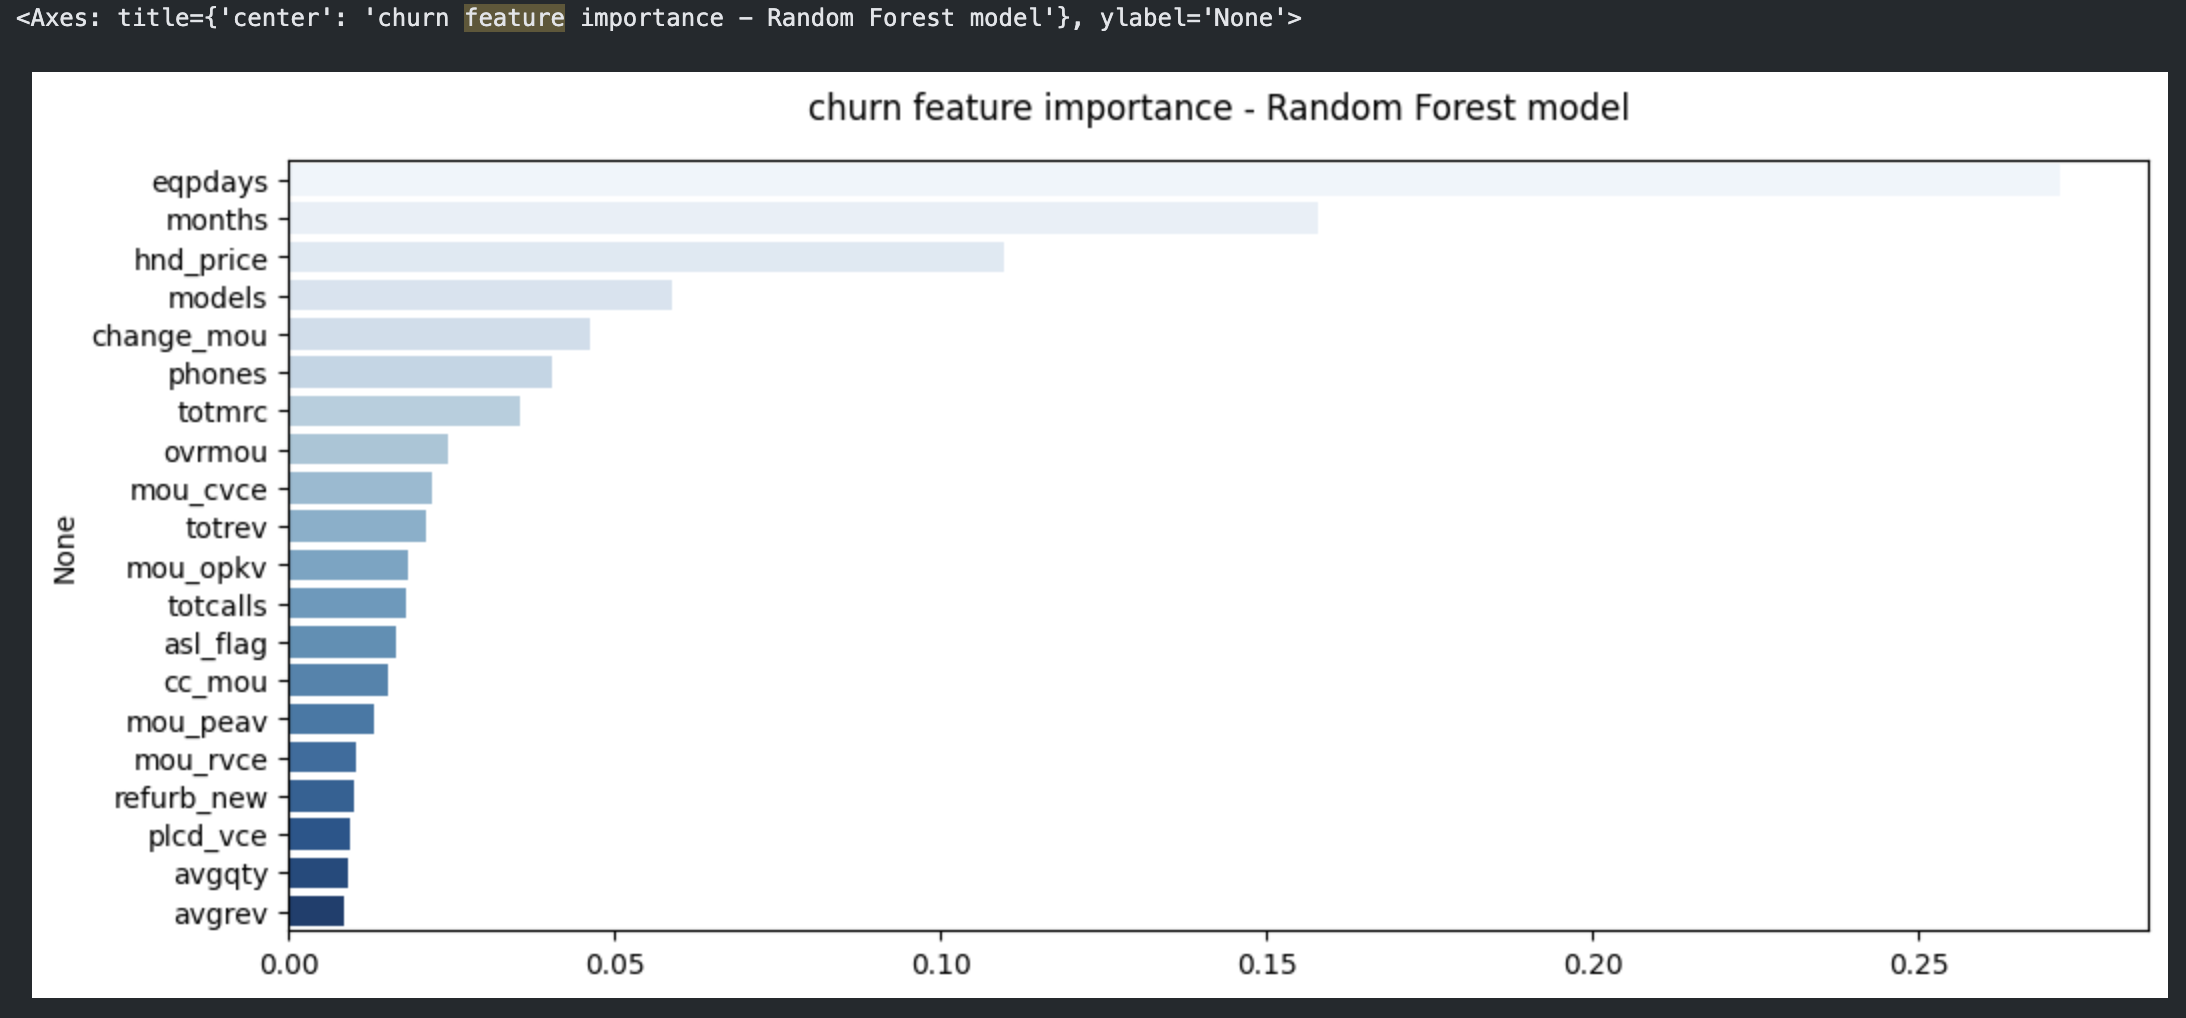

<Axes: title={'center': 'churn feature importance - CatBoost Classifier'}, ylabel='None'>

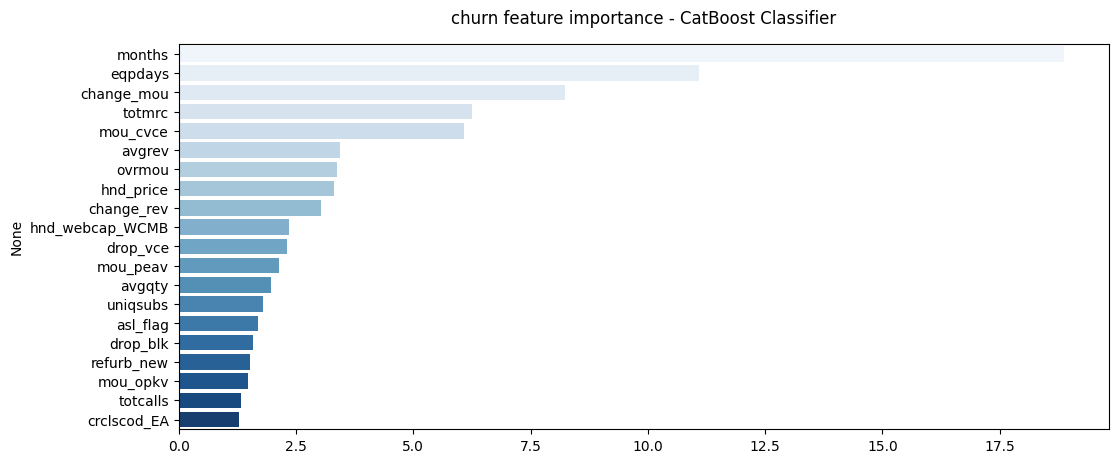

In [937]:
params = {'random_state': 42, 'thread_count': 4, 'n_estimators': 100, 'max_depth': 4, 'verbose':False}

forest = CatBoostClassifier(**params)
x,y = df_train.drop(columns=target), df_train[target]
forest.fit(x,y)
best_features = forest.feature_importances_
columns = x.columns
imp = pd.Series(data=best_features, index=columns).sort_values(ascending=False)

plt.figure(figsize=(12,5))
plt.title(f'{target} feature importance - CatBoost Classifier', pad=15)
sns.barplot(x=imp.values[:20], y=imp.index[:20], palette='Blues', orient='h')


In [938]:
print('Las 20 caracteristicas mas importantes:')
imp[:20]

Las 20 caracteristicas mas importantes:


months             18.878928
eqpdays            11.096165
change_mou          8.227304
totmrc              6.253363
mou_cvce            6.082392
avgrev              3.438882
ovrmou              3.374018
hnd_price           3.312143
change_rev          3.035318
hnd_webcap_WCMB     2.351475
drop_vce            2.315099
mou_peav            2.142068
avgqty              1.978940
uniqsubs            1.796537
asl_flag            1.698925
drop_blk            1.586776
refurb_new          1.515478
mou_opkv            1.481315
totcalls            1.331791
crclscod_EA         1.296807
dtype: float64

In [939]:
# probamos a eliminar columnas sin importancia
df_imp = imp.reset_index(name='importance')
df_imp['cumsum'] = df_imp['importance'].cumsum()
df_imp = df_imp[df_imp['importance']==0]
df_imp

,index,importance,cumsum
67,lor_4-6,0.0,100.0
68,marital_M,0.0,100.0
69,ethnic_S,0.0,100.0
70,marital_B,0.0,100.0
71,ethnic_U,0.0,100.0
72,ethnic_G,0.0,100.0
73,lor_7-9,0.0,100.0
74,mouowylisv,0.0,100.0
75,lor_10-12,0.0,100.0
76,ownrent_Unknown,0.0,100.0


In [940]:
#cols a eliminar
cols_eliminar = df_imp['index'].to_list()

# eliminamos columnas sin importancia para el CatBoost
df_train.drop(columns=cols_eliminar, inplace=True)
df_test.drop(columns=cols_eliminar, inplace=True)
df_pred.drop(columns=cols_eliminar, inplace=True)

print(f'num de columnas eliminadas: {len(cols_eliminar)}\n')
print(cols_eliminar)
print()
print(f'Nos quedamos con {df_train.shape[1]} columnas')


num de columnas eliminadas: 20

['lor_4-6', 'marital_M', 'ethnic_S', 'marital_B', 'ethnic_U', 'ethnic_G', 'lor_7-9', 'mouowylisv', 'lor_10-12', 'ownrent_Unknown', 'dualband_Y', 'prizm_social_one_Unknown', 'prizm_social_one_C', 'peak_dat', 'kid11_15', 'forgntvl', 'numbcars', 'mou_opkd', 'rv', 'truck']

Nos quedamos con 68 columnas


## Split train-test

In [941]:
X_train = df_train.drop(columns=target)
y_train = df_train[target]
X_test = df_test.drop(columns=target)
y_test = df_test[target]

## Rebalanceo del train

<Axes: xlabel='churn', ylabel='count'>

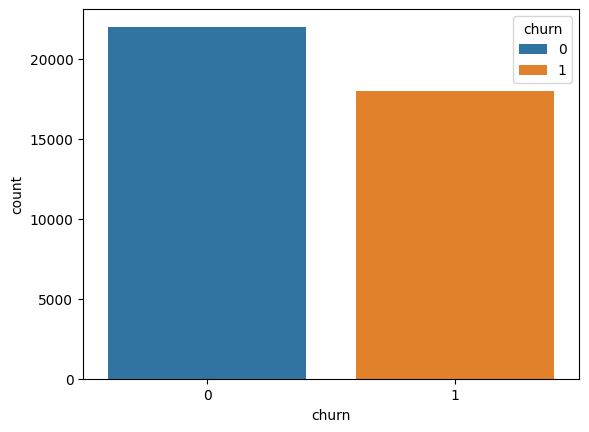

In [942]:
sns.countplot(data=df_train, x=target, hue=target)

In [943]:
# proporcion de cada clase de target
y_train.value_counts(normalize=True)

churn
0    0.550064
1    0.449936
Name: proportion, dtype: float64

In [944]:
# # Crear el undersampler
# undersampler = RandomUnderSampler(sampling_strategy=1.0, replacement=False, random_state=42)  # 1.0 = igualar clases

# # Aplicarlo solo al conjunto de entrenamiento
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [945]:
# proporcion de cada clase de target despues de rebalancear el train
y_train.value_counts(normalize=True)

churn
0    0.550064
1    0.449936
Name: proportion, dtype: float64

## Estandarización

In [946]:
escala = StandardScaler()

X_train = escala.fit_transform(X_train)
X_test = escala.transform(X_test)
X_pred = escala.transform(df_pred)

## Competición de modelos


Competir sobre el f1_score

In [947]:
modelos = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
    ('SGDClassifier_logloss', SGDClassifier(loss='log_loss')),
    ('SGDClassifier_hinge', SGDClassifier(loss='hinge')),
    ('SGDClassifier_modifiedhuber', SGDClassifier(loss='modified_huber')),
    ('SVC_linear', SVC(kernel='linear')),
    ('SVC', SVC()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('XGBClassifier', XGBClassifier()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=False))
]

In [948]:
# metricas_modelos = pd.DataFrame(columns=['modelo', 'F1_score'])

# for nombre, modelo in modelos:

#     modelo.fit(X_train, y_train)
#     y_pred = modelo.predict(X_test)

#     score = f1_score(y_test, y_pred)

#     metricas_modelos = pd.concat([metricas_modelos,
#                                 pd.DataFrame({'modelo':nombre, 'F1_score':score}, index=[0])])

# metricas_modelos.sort_values(by='F1_score', ascending=False)



## Hiperparametrización

In [949]:
# from sklearn.metrics import make_scorer

# # grid_params = {
# #     'depth': [6,8,10],
# #     'iterations' : [300, 600, 1000],
# #     'l2_leaf_reg': [3, 4, 5], 
# #     'loss_function': ['LogLoss', 'CrossEntropy'],
# #     'rsm': [0.8, 0.9, 1]
# # }

# grid_params = {
#     'depth': [8,10],
#     'iterations' : [600, 1000],
#     'l2_leaf_reg': [3, 4], 
#     'loss_function': ['LogLoss', 'CrossEntropy'],
#     'rsm': [0.8, 1]
# }

# modelo = CatBoostClassifier(random_state=42, verbose=False)

# f1_scorer = make_scorer(f1_score)

# grid_search = GridSearchCV(modelo, grid_params, scoring=f1_scorer, cv=3)
# grid_search.fit(X_train, y_train)

# print('Mejores parametros:', grid_search.best_params_)


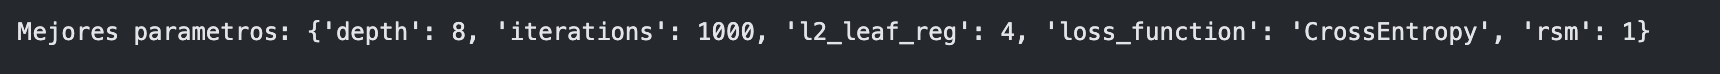

## Entrenamiento del modelo final

In [950]:
# # best_params
# best_params = {
#     #'depth': 10,
#     'depth': 8,
#     #'iterations' : 1000,
#     #'l2_leaf_reg': 4, 
#     #'loss_function': 'CrossEntropy',
#     #'rsm': 1,
#     'verbose': False,
#     'random_state': 42
#     }

# # entrenamiento
# modelo = CatBoostClassifier(**best_params)
# modelo.fit(X_train, y_train)

In [951]:
# entrenamiento
modelo = CatBoostClassifier(verbose=False, depth=6)
modelo.fit(X_train, y_train)

In [952]:
# predict
y_test_pred = modelo.predict(X_test)

In [953]:
# predict_proba
y_test_predict_proba = modelo.predict_proba(X_test)[:,1]

# Evaluación del modelo final

## AUC

Calcular el AUC con el predict_proba

In [954]:
roc_auc_score(y_test, y_test_predict_proba)

0.9349108383972691

In [955]:
roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1])

0.9724878673508781

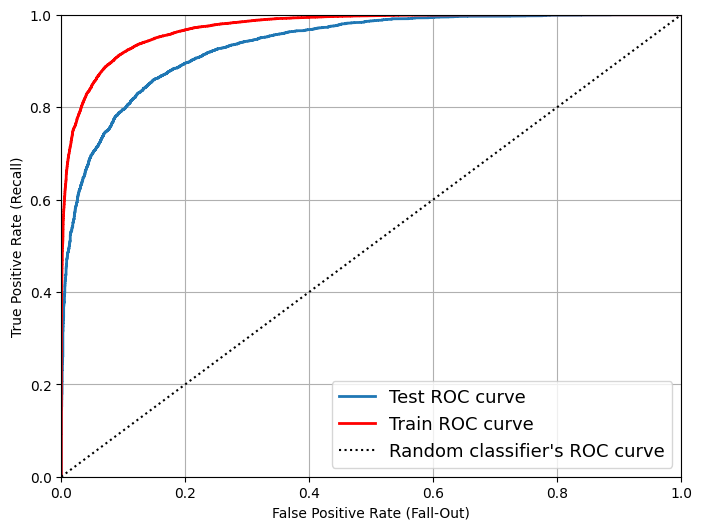

In [956]:
# Visualizacion de la ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_predict_proba)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, modelo.predict_proba(X_train)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label="Test ROC curve")
plt.plot(fpr_train, tpr_train, linewidth=2, label="Train ROC curve", color='r')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

## matriz de confusión

4764 verdaderos negativos
685 falsos positivos
765 falsos negativos
3786 verdaderos positivos


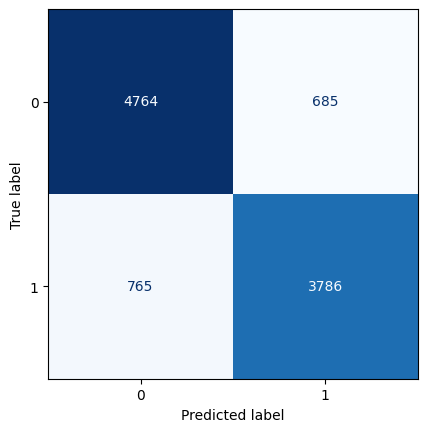

In [957]:
cm = confusion_matrix(y_test, y_test_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cm_display.plot(colorbar=False, cmap='Blues')

VN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
VP = cm[1][1]

print(f'{VN} verdaderos negativos')
print(f'{FP} falsos positivos')
print(f'{FN} falsos negativos')
print(f'{VP} verdaderos positivos')

## f1_score

In [958]:
modelo_score = f1_score(y_test, y_test_pred)
modelo_score

0.8392817557082687

# Guardar modelo

Guardar el modelo y lo que sea necesario para ejecutarlo (scaler)

In [959]:
# with open('modelo.pkl', 'wb') as f:
#     pickle.dump(modelo, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(escala, f)

# with open('encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# Interpretabilidad

## Modelo lineal

Si el mejor modelo ha sido un algoritmo basado en arbole de decisión, entrenamos el mejor modelo lineal de la competición de modelos, sin hiperparametrizar

Imprimir los coeficientes por variable + intercept

In [960]:
# modelo_lineal = SVC(kernel='linear')
# modelo_lineal.fit(X_train, y_train)

In [961]:
# print('intercept:', modelo_lineal.intercept_)

In [962]:
# df_coeficientes = pd.DataFrame(columns=['variable','coeficiente'])

# for col, coef in zip(X.columns, modelo_lineal.coef_[0]):

#     df_coeficientes = pd.concat([df_coeficientes, pd.DataFrame({'variable':col, 'coeficiente':coef}, index=[0])])

# df_coeficientes.sort_values(by='coeficiente', ascending=False)

Imprimir los coeficientes de las 10 variables con mayor impacto (positivo o negativo)

In [963]:
# df_coeficientes['coeficiente'] = np.abs(df_coeficientes['coeficiente'])
# top_10_coef = df_coeficientes.sort_values(by='coeficiente', ascending=False)[:10]
# top_10_coef

## Modelo de árbol de decisión

Si el mejor modelo ha sido un modelo lineal, entrenamos el mejor modelo basado en arboles de decisión, sin hiperparametrizar

&#x26a0;&#xfe0f;
El shap necesita el nombres de las variables. Estandarizar los datos los quita

### Shap values

In [964]:
# creamos df_X_test
df_X_test = pd.DataFrame(X_test, columns=escala.get_feature_names_out())
df_X_test

,rev,totmrc,ovrmou,roam,change_mou,change_rev,drop_vce,blck_vce,blck_dat,unan_vce,...,hnd_webcap_WCMB,ownrent_O,lor_0-3,lor_13-15,lor_Unknown,marital_S,marital_U,ethnic_H,ethnic_N,ethnic_other
0,0.059195,1.011549,-0.116087,-0.128726,1.183685,0.593043,0.069954,-0.280660,-0.027106,-0.141433,...,0.544847,-1.429384,1.611832,-0.366257,-0.613422,2.087460,-0.759032,-0.395527,1.375113,-0.380299
1,-0.156208,-0.224323,0.003128,-0.128726,-0.315257,-0.221796,0.473168,-0.309657,-0.027106,1.369215,...,0.544847,-1.429384,1.611832,-0.366257,-0.613422,-0.479051,-0.759032,-0.395527,1.375113,-0.380299
2,0.973692,1.181830,-0.404588,-0.128726,0.583132,0.289644,0.289889,-0.164670,-0.027106,1.242625,...,0.544847,0.699602,-0.620412,-0.366257,-0.613422,2.087460,-0.759032,-0.395527,1.375113,-0.380299
3,0.003710,0.261773,-0.094628,-0.128726,0.423961,-0.208401,-0.589851,0.647257,-0.027106,-0.647796,...,-1.835378,-1.429384,-0.620412,-0.366257,1.630200,-0.479051,1.317468,2.528273,-0.727213,-0.380299
4,-0.114276,0.261773,-0.290142,-0.128726,-0.328929,-0.067463,1.866089,0.009314,-0.027106,1.031640,...,-1.835378,0.699602,-0.620412,-0.366257,-0.613422,-0.479051,-0.759032,-0.395527,-0.727213,-0.380299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.392180,-0.170276,-0.228150,-0.004558,-0.188311,-0.243382,-0.479883,-0.367652,-0.027106,-0.605599,...,0.544847,0.699602,-0.620412,-0.366257,-0.613422,-0.479051,-0.759032,-0.395527,1.375113,-0.380299
9996,-1.165306,-2.535789,-0.404588,-0.128726,0.057769,0.039193,-0.663162,-0.367652,-0.027106,-0.715311,...,0.544847,0.699602,1.611832,-0.366257,-0.613422,-0.479051,-0.759032,-0.395527,-0.727213,-0.380299
9997,-0.602163,-0.660688,-0.404588,-0.128726,0.080229,0.007450,-0.553195,-0.280660,-0.027106,-0.706872,...,-1.835378,0.699602,-0.620412,-0.366257,-0.613422,-0.479051,-0.759032,-0.395527,1.375113,-0.380299
9998,0.445307,0.756596,0.158108,-0.128726,0.969830,2.905383,-0.479883,-0.193668,-0.027106,-0.580281,...,0.544847,0.699602,-0.620412,2.730322,-0.613422,2.087460,-0.759032,-0.395527,-0.727213,-0.380299


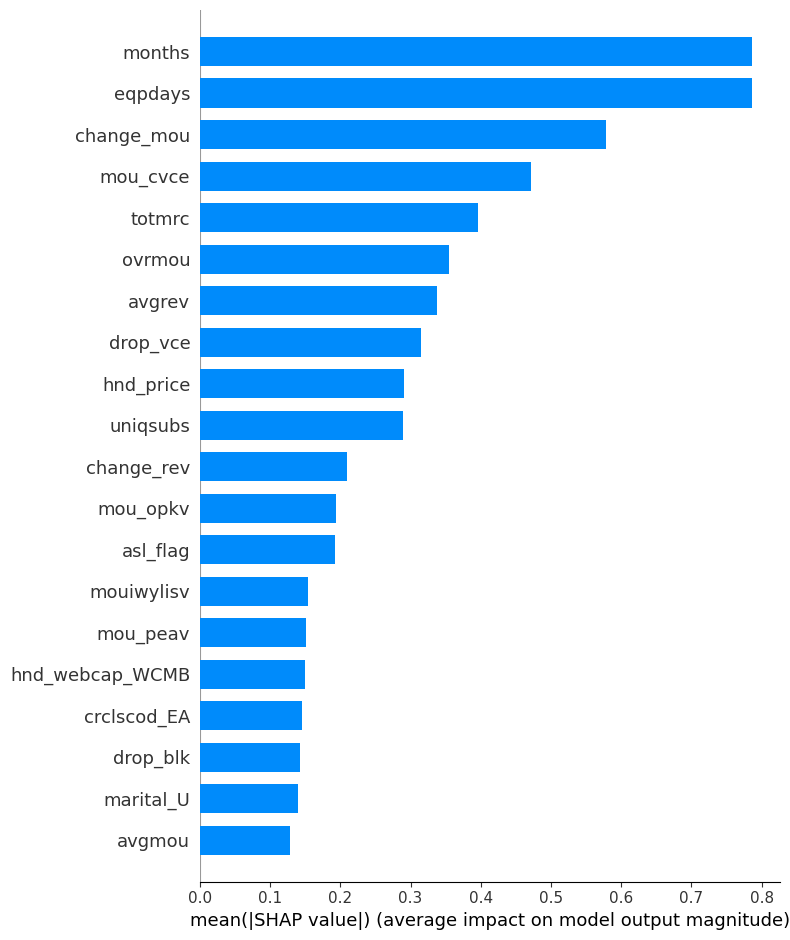

In [965]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(df_X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, df_X_test, plot_type="bar", max_display=20)

### Summary_plot

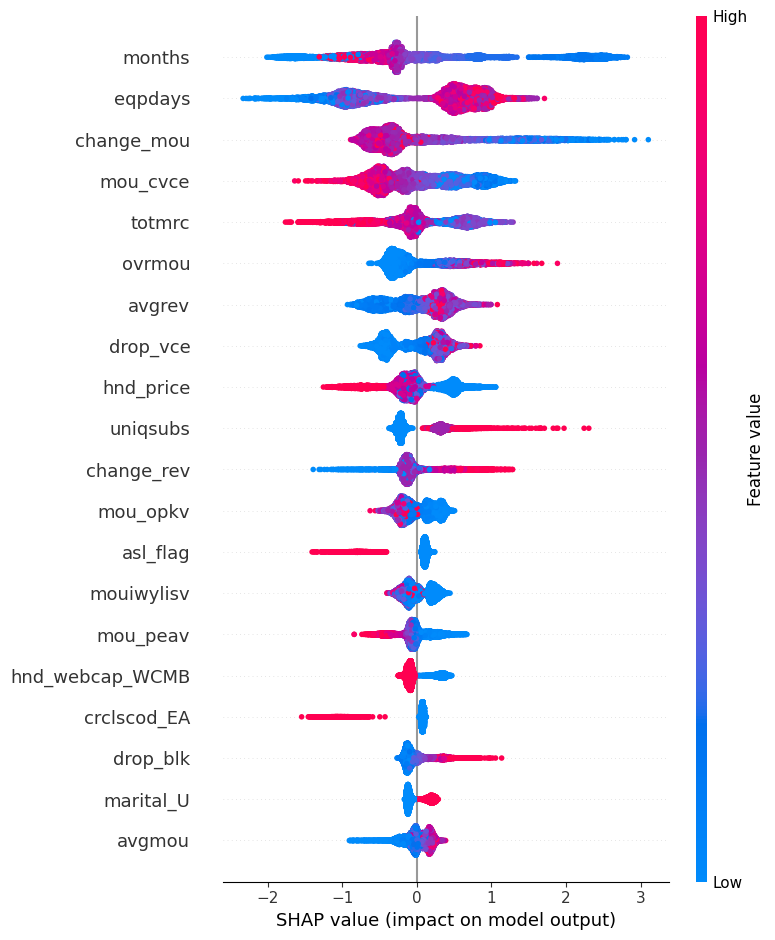

In [966]:
shap.summary_plot(shap_values, df_X_test)

## Interpretabilidad top 5 variables

Explicar muy brevemente cuales son las 5 variables que más impactan en el churn, y si el impacto es positivo o negativo.

Variables mas importantes: 
- months: impacto negativo. En general los clientes con months bajos tienen mas probabilidad de churn = 1. Los clientes con months altos estan algo mas dispersos, vemos que en algunos casos el hecho de que los months sean mas altos aumentan la probabilidad de churn = 1, lo que puede estar relacionado con el final de ciertas promociones, o que la compania lleva tiempo sin hacer engagement con estos clientes

- eqpdays: impacto positivo. Los valores muy altos tienen mas probabilidad de churn = 1
- change_mou: impacto negativo. A menor uso mensual con respecto a los ultimos 3 meses, mayor probabilidad de churn=1
- mou_cvce: impacto negativo. A menor numero de minutos en llamada, mayor probabilidad de churn=1
- totmrc: impacto negativo. A menor recarga de saldo mensual, mayor probabilidad de churn=1

# Predicción

&#x26a0;&#xfe0f;
Realizar la predicción sobre el 100% de los clientes a predecir.  


&#x26a0;&#xfe0f;
Asegurarse de hacer la predicción en las mismas condiciones que el entrenamiento

In [967]:
# entrenamos el modelo con el 100% de nuestros datos

df_total = pd.concat([df_train, df_test]).reset_index(drop='index')

X = df_total.drop(columns=target)
y = df_total[target]

In [968]:
y.value_counts(normalize=True)

churn
0    0.549031
1    0.450969
Name: proportion, dtype: float64

In [969]:
# # resampleamos como en el entrenamiento
# undersampler = RandomUnderSampler(sampling_strategy=1.0, replacement=False, random_state=42)  # 1.0 = igualar clases
# X, y = undersampler.fit_resample(X, y)

In [970]:
y.value_counts(normalize=True)

churn
0    0.549031
1    0.450969
Name: proportion, dtype: float64

In [971]:
# escalamos como en el entrenamiento
X_escalado = escala.transform(X)
modelo.fit(X_escalado, y)

In [972]:
predicciones = modelo.predict(X_pred)
predicciones

array([1, 0, 0, ..., 0, 0, 1])

Imprimir los 20 clientes más propensos a irse

In [973]:
modelo.predict_proba(X_pred)[:,1]

array([0.98614588, 0.28063604, 0.16121248, ..., 0.13421717, 0.31802059,
       0.8990284 ])

In [974]:
df_top_20_pred = pd.DataFrame({'customer_id': customer_id_pred, 'predict': predicciones, 'predict_proba': modelo.predict_proba(X_pred)[:,1]}).sort_values(by='predict_proba', ascending=False)[:20]
df_top_20_pred

,customer_id,predict,predict_proba
181,1011100,1,0.999685
1185,1070106,1,0.999348
1171,1069466,1,0.998959
1218,1072363,1,0.998667
449,1025343,1,0.998659
1058,1063840,1,0.998498
884,1052984,1,0.998474
986,1059594,1,0.998334
1422,1085925,1,0.998247
1464,1088008,1,0.998193


Imprimir el len del archivo de predicción

In [975]:
len(predicciones)

1500

# Exportar predicción

Exportar un archivo excel con solamente 3 columnas, llamadas 'customer_id', 'predict' y 'predict_proba', **en minúscula**

In [976]:
df_predicciones_resultado = pd.DataFrame({'customer_id': customer_id_pred, 'predict': predicciones, 'predict_proba': modelo.predict_proba(X_pred)[:,1]}).sort_values(by='predict_proba', ascending=False)
df_predicciones_resultado

,customer_id,predict,predict_proba
181,1011100,1,0.999685
1185,1070106,1,0.999348
1171,1069466,1,0.998959
1218,1072363,1,0.998667
449,1025343,1,0.998659
...,...,...,...
299,1017148,0,0.001170
537,1030816,0,0.001121
1001,1060609,0,0.001115
36,1002805,0,0.000869


In [977]:
print('712 churn=1')

712 churn=1


In [978]:
df_predicciones_resultado['predict'].value_counts()

predict
0    832
1    668
Name: count, dtype: int64

In [979]:
# df_predicciones_resultado.to_excel('df_predicciones_resultado.xlsx')